<a href="https://colab.research.google.com/github/hillerj1/PHY_310/blob/main/FiniteDifference_Eigenstates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 7: The Finite Difference Method

## Library Imports Go Here

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh
from numpy.linalg import eigh

## A Generic Finite Difference Matrix Creation Function

<font color = blue>
We are interested in solving the general equation type

$$
A(x)u'' + B(x)u' + C(x)u = \lambda u
$$

subject to the boundary conditions

$$
u(0) = u(x_{\infty}) = 0
$$

(by which we mean that we want to find both the eigenvalue $\lambda$ and the eigenfunction $u(x)$.)  The basic approach used today will be to transform this equation into a matrix equation in the form

$$
\mathbb{M}\vec{u} = \lambda\vec{u}
$$

and the focus will be on generating the matrix $\mathbb{M}$, which we can then use existing python functions from the scipy.sparse and the scipy.linalg modules to analyze.

### A Matrix Generating Function

<font color = blue>
    
Construct a function that takes as inputs the three functions $A(x)$, $B(x)$, and $C(x)$, along with `matrix_size` = $N$, the total size-length of the matrix and $x_{\infty}$ the value of "numerical infinity", and outputs the matrix $\mathbb{M}$ (as an array.)  Test your matrix generator with $A = B = C = 1$, $x_{\infty} = 1$, and $N = 5$, and show the result.  Confirm that the entries to the matrix are correct with calculations included in a **discussion**.

In [ ]:
def arrayMatrix(A, B, C, N, x_inf):
    del_x = x_inf / (N+1)
    matrix = np.zeros((N, N))

    for i in range(N):
        matrix[i, i] = C(i) - ((2 * A(i)) / del_x**2)

    for i in range(1, N):
        matrix[i, i-1] = (A(i)/del_x**2) + (B(i)/(2*del_x))
        matrix[i-1, i] = (A(i)/del_x**2) - (B(i)/(2*del_x))

    return matrix

def A(x):
    return 1
def B(x):
    return 1
def C(x):
    return 1
N = 5
x_inf = 1

arrayMatrix(A, B, C, N, x_inf)[1,1]

-71.0

The matrix \( M \) should have the following form:

\[
M = \begin{bmatrix}
M_{jj} & M_{j+1} & 0 & 0 & 0 \\
M_{j-1} & M_{jj} & M_{j+1} & 0 & 0 \\
0 & M_{j-1} & M_{jj} & M_{j+1} & 0 \\
0 & 0 & M_{j-1} & M_{jj} & M_{j+1} \\
0 & 0 & 0 & M_{j-1} & M_{jj}
\end{bmatrix}
\]

Since $M_{jj} = C_j - \frac{A_j}{\Delta x^2} = -71$

$M_{j+1} = (\frac{A_j}{\Delta x^2} + \frac{B_j}{2 \Delta x}) = 33$

$M_{j-1} = (\frac{A_j}{\Delta x^2} - \frac{B_j}{2 \Delta x}) = 39$



Substituting \( A = B = C = 1 \), we should get the following:

\[
M = \begin{bmatrix}
-71 & 33 & 0 & 0 & 0 \\
39 & -71 & 33 & 0 & 0 \\
0 & 39 & -71 & 33 & 0 \\
0 & 0 & 39 & -71 & 33 \\
0 & 0 & 0 & 39 & -71
\end{bmatrix}
\]

And this is what the program outputs.

### A Sparse Matrix Generating Function

<font color = blue>
There are many numerical methods that find the eigenvalues and eigenvectors of a matrix, but they are definitely not all created equal.  Even though we aren't learning the algorithms behind these methods, it is still useful to consider some of their differences.

```
```

There are a set of algorithms specifically designed to work on matrices which are "sparse", meaning that most of the elements in them are zero.  However, in order to use these algorithms, we have to create and store the matrix in a way other than the standard numpy array.  What we want to do here is write a second function for creating a matrix, but this time store it as a "sparse" matrix type.  

```
```

To do this you will need to use the library scipy.sparse.  There is more than one sparse matrix type (the differences are in how the data is stored in your computer), but the easiest one to create is the "coo" type, so you will need to use the function coo_matrix in the scipy.sparse library.  

```
```

Once you have your function for creating the matrix, you can take its output and convert it into a standard array using .toarray().  (This is helpful for making sure this code produces the same matrix you've just confirmed is correct in the previous code -- but make sure your function doesn't do this internally, because that will defeat the point!)

In [ ]:
def sparseMatrix(A, B, C, N, x_inf):
    '''
    Takes a set of functions and creates a sparse matrix,
    seperating the non-zero values of the matrix and returning them with
    their corresponding indexes.
    '''
    del_x = x_inf / (N+1)

    diag_row  = np.array([i for i in range(0, N)])
    diag_col  = np.array([i for i in range(0, N)])
    diag_data = np.array([C(del_x * i) - ((2 * A(del_x * i)) / del_x**2) for i in range(0, N)])

    up_row  = np.array([i for i in range(0, N-1)])
    up_col  = np.array([i for i in range(1, N)])
    up_data = np.array([(A(del_x * i)/del_x**2) - (B(del_x * i)/(2*del_x)) for i in range(1, N)])

    down_row  = np.array([i for i in range(1, N)])
    down_col  = np.array([i for i in range(0, N-1)])
    down_data = np.array([(A(del_x * i)/del_x**2) + (B(del_x * i)/(2*del_x)) for i in range(1, N)])

    rows = np.concatenate((diag_row, up_row, down_row))
    cols = np.concatenate((diag_col, up_col, down_col))
    data = np.concatenate((diag_data, up_data, down_data))

    return sparse.coo_matrix((data, (rows, cols)), shape=(N, N))


#Checking and printing matricies
print('using matrix array function:')
print(arrayMatrix(A, B, C, N, x_inf))
print('using matrix sparse function:')
print(sparseMatrix(A, B, C, N, x_inf))
print('using matrix sparse function with .toarray() to check:')
print(sparseMatrix(A, B, C, N, x_inf).toarray())

using matrix array function:
[[-71.  33.   0.   0.   0.]
 [ 39. -71.  33.   0.   0.]
 [  0.  39. -71.  33.   0.]
 [  0.   0.  39. -71.  33.]
 [  0.   0.   0.  39. -71.]]
using matrix sparse function:
  (0, 0)	-71.0
  (1, 1)	-71.0
  (2, 2)	-71.0
  (3, 3)	-71.0
  (4, 4)	-71.0
  (0, 1)	33.0
  (1, 2)	33.0
  (2, 3)	33.0
  (3, 4)	33.0
  (1, 0)	39.0
  (2, 1)	39.0
  (3, 2)	39.0
  (4, 3)	39.0
using matrix sparse function with .toarray() to check:
[[-71.  33.   0.   0.   0.]
 [ 39. -71.  33.   0.   0.]
 [  0.  39. -71.  33.   0.]
 [  0.   0.  39. -71.  33.]
 [  0.   0.   0.  39. -71.]]


### The Comparison

<font color = blue>
    
Here, we will compare the efficiency of a method which uses sparse techniques with one that doesn't.  We will use the infinite square well system as an example, where

$$
A(x) = -1, \hspace{.75in} B(x) = C(x) = 0
$$

and

$$
x_{\infty} = 1
$$

For your standard numpy array matrix, use the function `eigh` from the `numpy.linalg` module.  For your sparse coo-type matrix use the function `eigsh` from the `scipy.sparse.linalg` module.  (Note that both of these functions assume the matrix you are providing is Hermetian, which when finding the energy eigenstates in quantum mechanics you always have.)

One thing to be aware of is that the "sparse" function is designed to generate only a subset of the total eigenvalues and eigenvectors (specified by a parameter `k`, which here we will set to 1.)  Furthermore, they are naturally ordered from largest magnitudes of eigenvalues to smallest.  We are more interested in the smallest magnitude eigenvalues, which we can get out by setting the parameter `sigma = 0`.  

Using each of these two functions, determine the time required to compute the first eigenvalue/eigenvector for `matrix_size` = N in the range $[10, 1000]$, in steps of $10$.  Plot these two sets of times together on the same graph, and **discuss** which method is more efficient.

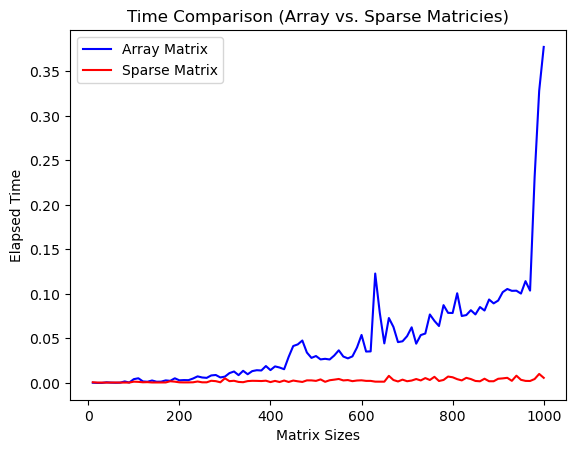

In [ ]:
def A(x):
    return -1
def B(x):
    return 0
def C(x):
    return 0

# Defining initial conditions
x_inf = 1
sizes = np.arange(10, 1010, 10)
time_dense = np.zeros((len(sizes),))
time_sparse = np.zeros((len(sizes),))

for i in range(len(sizes)):
    start_time = time.time()
    full_matrix = arrayMatrix(A, B, C, sizes[i], x_inf)
    np.linalg.eigh(full_matrix)
    end_time = time.time()
    time_dense[i] = end_time - start_time

    start_time = time.time()
    sparse_matrix = sparseMatrix(A, B, C, sizes[i], x_inf)
    sparse.linalg.eigsh(sparse_matrix, k=1, sigma=0)
    end_time = time.time()
    time_sparse[i] = (end_time - start_time)

plt.plot(sizes, time_dense, color = 'b', label = 'Array Matrix')
plt.plot(sizes, time_sparse, color = 'r', label = 'Sparse Matrix')
plt.title('Time Comparison (Array vs. Sparse Matricies)')
plt.xlabel('Matrix Sizes')
plt.ylabel('Elapsed Time')
plt.legend()
plt.show()

This graph shows that the time my computer takes to calculate the eigenvalue/eigenvector for a given matrix is quicker when it is given a sparse matrix as opposed to a full matrix. Above you can see that the full array matrix increases exponentially as N increases, while the sparse matrix function seems to increase linearly if at all. Clear the sparse matrix is more efficient, most likely because it naturally leaves out the indexes with 0 values.

## The Hydrogen Energy Spectrum

<font color = blue>
    
Now we want to analyze the Hydrogen atom, where we are trying to solve the equation (in dimensionless form, as usual)

$$
-u'' + \frac{\ell(\ell+1)}{r^2}u - \frac{2}{r}u + u = \hat{E}u
$$

Remember that here, length is measured in units of the Bohr radius, and energy is measured in units of the Rydberg energy, but with an upward shift of $+1$ so that $\hat{E} = \tilde{E} + 1$ and all of the eigenvalues will come out positive.

The value $\ell$ is the quantum number associated with the magnitude of angular momentum.  With this non-dimensionalization, the energy spectrum should be

$$
\hat{E}_n = 1 - \frac{1}{n^2}, \hspace{.5in} \tilde{E}_n = -\frac{1}{n^2} \, .
$$

### Preliminaries

<font color = blue>
    
First create a function that takes as input the value of $\ell$ as well as the choice of "numerical infinity" and the matrix size, and outputs the appropriate (sparse) matrix.

In [ ]:
def preliminary(l, inf, size):
    '''
    preliminary function that assigns 3 functions to the sparse matrix procedure.
    the C(x) func is the only one with a component.
    '''
    def A(x):
        return -1.0
    def B(x):
        return 0.0
    def C(x):
        if x != 0:
            return ((l* (l+1)) / ((x**2)) - (2/x) + 1)
        else:
            return 0
    return sparseMatrix(A, B, C, size, inf)

### Eigenvalues

#### * Zero Angular Momentum States

<font color = blue>
    
Now, use your function to genererate the energy spectrum of the lowest ten energies of hydrogen, with $\ell = 0$. Create arrays with entries $[n]$ and $[\tilde{E}_n]$, and plot this together with a curve showing the theoretical spectrum.  (Don't forget to shift the energies back from $\hat{E}$ to $\tilde{E}$!)  For this exercise, use $x_{\infty} = 1000$ and $N = 100000$.  **Discuss** the results.

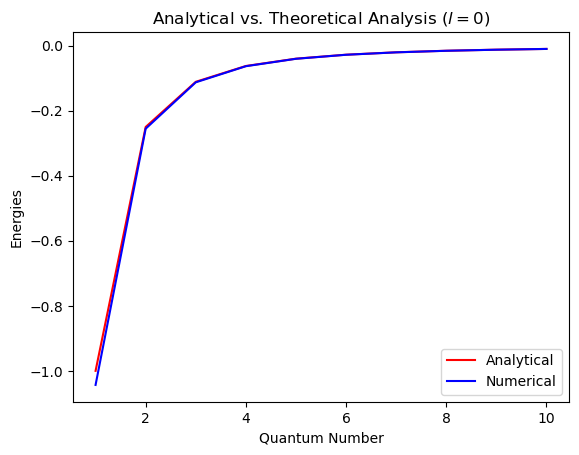

In [ ]:
prelim = preliminary(0, 1000, 100000)

def theory_spec(n):
    return -1/(n)**2

num = 10
n = np.arange(1,num+1,1)
energies = np.array([theory_spec(x) for x in n])

e_hat, e_vec = sparse.linalg.eigsh(prelim, k = num, sigma = 0)

e_n = e_hat - 1

plt.plot (n, energies, color = 'r', label = 'Analytical')
plt.plot(n, e_n, color = 'b', label = 'Numerical')
plt.title(r'Analytical vs. Theoretical Analysis ($l = 0$)')
plt.xlabel('Quantum Number')
plt.ylabel('Energies')
plt.legend()
plt.show()

When plotting eigenvalue energies vs. quantum numbers, the theoretical equation is stated above, I expected to find numerical values that proved this equation. As you can see above the values seem to be very similar. The code find the 10 fewest eigenvalues for the hydrogen energy spectrum by using the sparse.linalg.eigsh function in SciPy.

#### * Non-Zero Angular Momentum States

<font color = blue>
    
Then, use your function to also generate lists of energies for $\ell = 1$ and $\ell = 2$.  (Use the same $x_{\infty}$ and $N$ values.)

Create a graph showing all three values of $\ell$.  Put energy on the vertical axis, and $\ell$-value on the horizontal axis.  Add horizontal lines at each energy level.  **Discuss** the results.

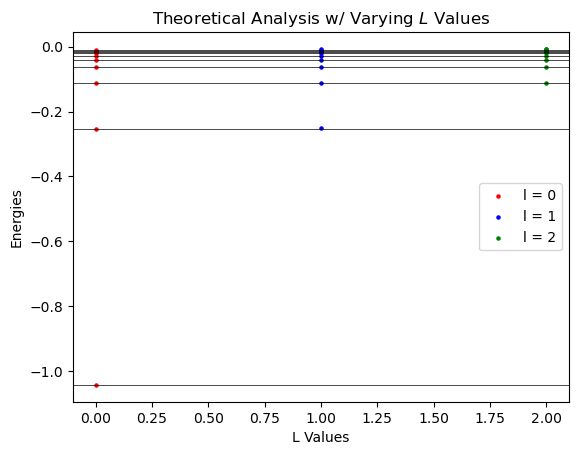

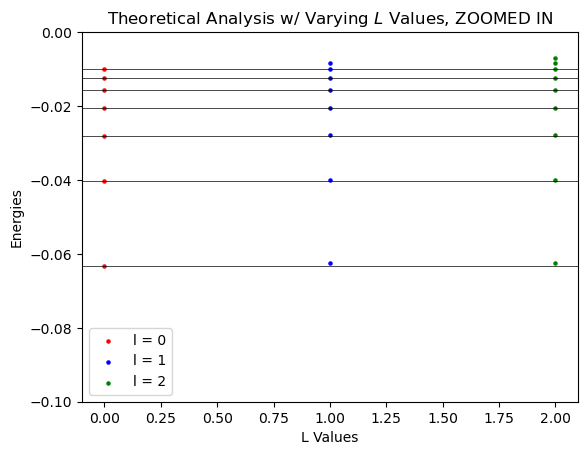

In [ ]:
prelim0 = preliminary(0, 1000, 100000)
prelim1 = preliminary(1, 1000, 100000)
prelim2 = preliminary(2, 1000, 100000)

l = np.array([[0]*10, [1]*10, [2]*10])

e_hat0, e_vec0 = sparse.linalg.eigsh(prelim0, k = 10, sigma = 0)
e_n0 = e_hat0 - 1
e_hat1, e_vec1 = sparse.linalg.eigsh(prelim1, k = 10, sigma = 0)
e_n1 = e_hat1 - 1
e_hat2, e_vec2 = sparse.linalg.eigsh(prelim2, k = 10, sigma = 0)
e_n2 = e_hat2 - 1

for i in range(len(e_n0)):
    plt.axhline(y = e_n0[i], linewidth = .5, color = 'black')
plt.scatter(l[0], e_n0, color = 'r', label = 'l = 0', s = 5)
plt.scatter(l[1], e_n1, color = 'b', label = 'l = 1', s = 5)
plt.scatter(l[2], e_n2, color = 'g', label = 'l = 2', s = 5)
plt.title(r'Theoretical Analysis w/ Varying $L$ Values')
plt.xlabel('L Values')
plt.ylabel('Energies')
plt.legend()
plt.show()

for i in range(len(e_n0)):
    plt.axhline(y = e_n0[i], linewidth = .5, color = 'black')
plt.scatter(l[0], e_n0, color = 'r', label = 'l = 0', s = 5)
plt.scatter(l[1], e_n1, color = 'b', label = 'l = 1', s = 5)
plt.scatter(l[2], e_n2, color = 'g', label = 'l = 2', s = 5)
plt.title(r'Theoretical Analysis w/ Varying $L$ Values, ZOOMED IN')
plt.xlabel('L Values')
plt.ylabel('Energies')
plt.ylim(-.1, 0)
plt.legend()
plt.show()

The graphs above show a clearer hydrogen energy spectrum, where you can clearly see the similarities in quantum numbers in comparison to the $l$ values given.

### Eigenvectors

#### * Anaytlic Comparisons

<font color = blue>
    
Now let's make some comparisons between the eigenvectors generated numerically and the known analytic functions for the radial wavefunction $R(r)$.  Use the "eigsh" function to generate the eigenvectors associated with the sets of quantum numbers $(n = 1, \ell = 0)$, $(n = 2, \ell = 0)$, and $(n = 2, \ell = 1)$.  For this, use $x_{\infty} = 1000$ and $N = 100000$.  Convert these lists into discrete approximations of the radial wavefunction

$$
R(r) = \frac{u(r)}{r}
$$

In addition, create a list of $r$-coordinates $[r_n]$.  Then plot each, together with its analytic, known solution:

$$
n = 1, \ell = 0: \hspace{.5in} R(r) \propto e^{-r}
$$

$$
n = 2, \ell = 0: \hspace{.5in} R(r) \propto \left(1 - \frac{r}{2}\right)e^{-r/2}
$$

$$
n = 2, \ell = 1: \hspace{.5in} R(r) \propto r e^{-r/2}
$$

(you will have to manually "tune" a constant of proportionality in each case until it fits well -- wavefunctions are normalized according to a probability requirement, but the eigenvectors will automatically satisfy a different normalization condition.)

**Discuss** the results.

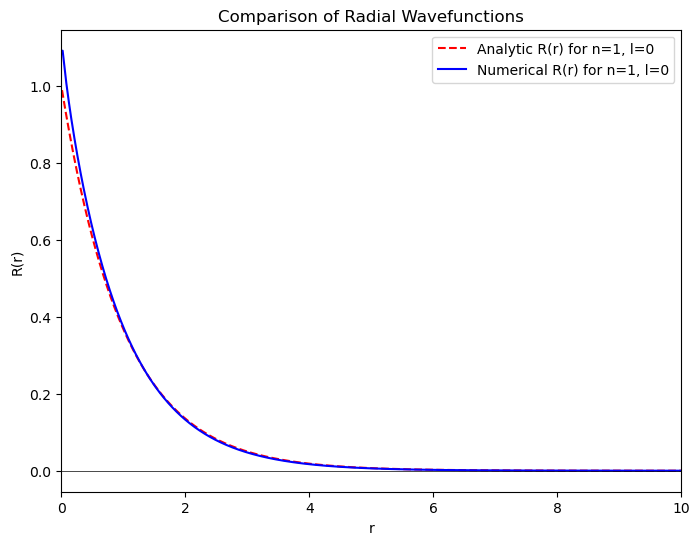

In [ ]:
N = 100000
x_inf = 1000
prelim = preliminary(0, x_inf, N)
cons = -5 # found using guess and check
def R(r):
    return np.exp(-r)

del_r = x_inf/(1+N)
r = np.linspace(del_r, N * del_r, N)


e_hat, e_vec = sparse.linalg.eigsh(prelim, k=3, sigma=0)
e_n = e_hat - 1

def radial_wavefunction(u_vec, r):
    return (u_vec / r) *cons

u_numerical = e_vec[:, 0]

R_numerical = radial_wavefunction(u_numerical, r)

plt.figure(figsize=(8, 6))
plt.plot(r, R(r), label='Analytic R(r) for n=1, l=0', color='r', linestyle='--')
plt.plot(r, R_numerical, label='Numerical R(r) for n=1, l=0', color='b')
plt.title('Comparison of Radial Wavefunctions')
plt.xlabel('r')
plt.ylabel('R(r)')
plt.xlim(0, 10)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.legend()
plt.show()

Since both the analytic and numerical functions I am plotting are non-dimensionalized, the physical proproties of this graph are not as apparent. But the graph above represents the ground state hydrogen spectrum when the hydrogen atom is at the Bohr Radius ($a_0$), here represented by 1 on the $R(r)$ axis. As the atom gets farther from the nucleus the probability density falls off dramatically.

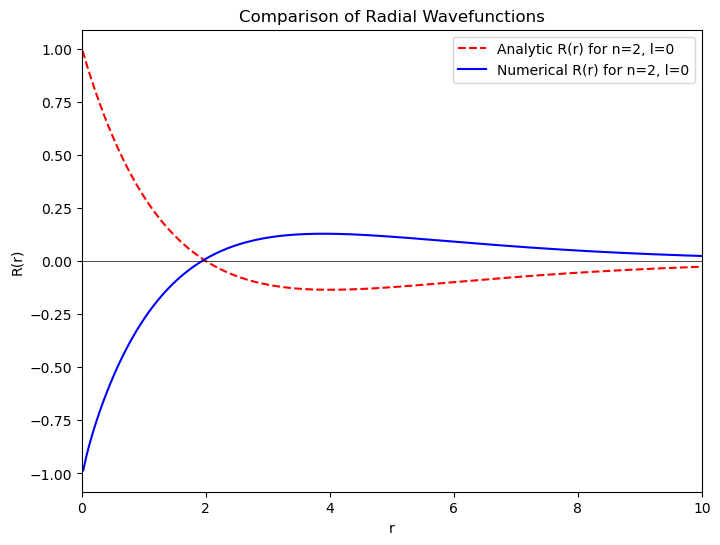

In [ ]:
N = 100000
x_inf = 1000
prelim = preliminary(0, x_inf, N)
cons = 13 # found using guess and check
def R(r):
    return (1 - (r/2)) * np.exp(-r/2)

del_r = x_inf/(1+N)
r = np.linspace(del_r, N * del_r, N)


e_hat, e_vec = sparse.linalg.eigsh(prelim, k=3, sigma=0)
e_n = e_hat - 1

def radial_wavefunction(u_vec, r):
    return (u_vec / r) *cons

u_numerical = e_vec[:, 1]

R_numerical = radial_wavefunction(u_numerical, r)

plt.figure(figsize=(8, 6))
plt.plot(r, R(r), label='Analytic R(r) for n=2, l=0', color='r', linestyle='--')
plt.plot(r, R_numerical, label='Numerical R(r) for n=2, l=0', color='b')
plt.title('Comparison of Radial Wavefunctions')
plt.xlabel('r')
plt.ylabel('R(r)')
plt.xlim(0, 10)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.legend()
plt.show()

The graph above represents the 2nd location a hydrogren atom has the potential to be found. Meaning the probability density is at its second highest point. The hump in the graph above over the x-axis shows where the hydrogen atom would have a higher energy in the n=2 state. Given by another quantum number, these are all probablilty distributions of a hydrogen atom being found in this location from the nucleous.

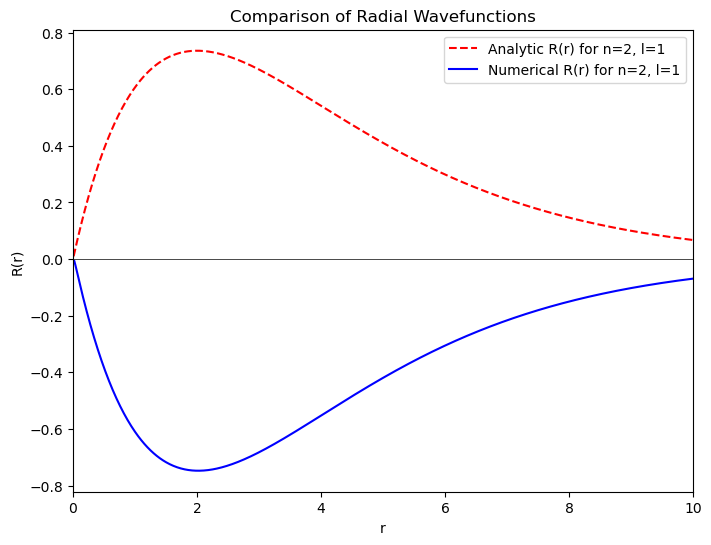

In [ ]:
N = 100000
x_inf = 1000
prelim = preliminary(1, x_inf, N)
cons = -50 # found using guess and check
def R(r):
    return r * np.exp(-r/2)

del_r = x_inf/(1+N)
r = np.linspace(del_r, N * del_r, N)


e_hat, e_vec = sparse.linalg.eigsh(prelim, k=3, sigma=0)
e_n = e_hat - 1

def radial_wavefunction(u_vec, r):
    return (u_vec / r) *cons

u_numerical = e_vec[:, 0]

R_numerical = radial_wavefunction(u_numerical, r)

plt.figure(figsize=(8, 6))
plt.plot(r, R(r), label='Analytic R(r) for n=2, l=1', color='r', linestyle='--')
plt.plot(r, R_numerical, label='Numerical R(r) for n=2, l=1', color='b')
plt.title('Comparison of Radial Wavefunctions')
plt.xlabel('r')
plt.ylabel('R(r)')
plt.xlim(0, 10)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.legend()
plt.show()

In the graph above now that l=1, there is a component of angular momentum that effects the energy as the hydrogen atom gets further from the bohr radius. The probility distribution because more spread out as the atom gets further away from the nucleous at a less dramatic pace as in the l=0 state.

#### The Role of $\Delta x$

<font color = blue>
    
We would now like to examine the roll that $\Delta x$ plays in limiting the accuracy and applicability of our numerical method.  To do so, consider the radial wavefunction $R(r)$ with $n = 4$ and $\ell = 1$.  Create plots of this wavefunction for different values of `matrix_size` = $N$:

$$N = \{100000, 10000, 1000, 100\}$$

all with $x_{\infty} = 1000.$  (Note that the normalization of the eigenvector will change as you change $N$.)

This corresponds to four different choices of $\Delta x$.  **Discuss** the results.  What, in general, must be true of $\Delta x$ in order for the finite different method to work well (on a particular wavefunction)?

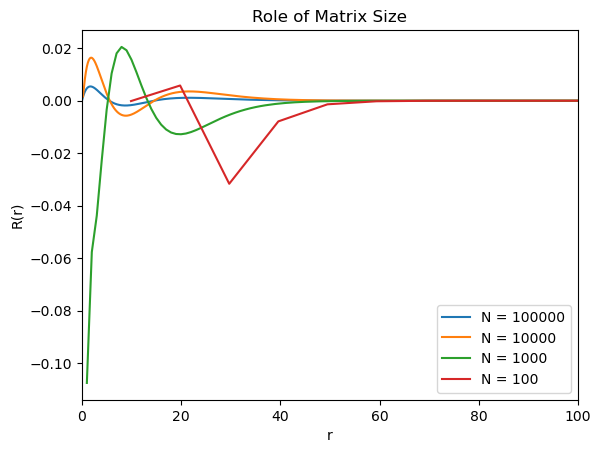

In [ ]:
N = np.array([100000, 10000, 1000, 100])
for i in range(len(N)):
    del_r = 1000/(1+ N[i])
    r = np.linspace(del_r, N[i] * del_r, N[i])

    prelim_N = preliminary(1, 1000, N[i])

    e_hat, e_vec = sparse.linalg.eigsh(prelim_N, k=3, sigma=0)
    e_n = e_hat - 1

    def radial_wavefunction(u_vec, r):
        return (u_vec / r)

    u_numerical = e_vec[:, 2]
    R_numerical = radial_wavefunction(u_numerical, r)

    plt.plot(r, R_numerical, label=f'N = {N[i]}')

plt.title('Role of Matrix Size')
plt.xlabel('r')
plt.ylabel('R(r)')
plt.xlim(0, 100)
plt.legend()
plt.show()

As we can see from the graph above, when $\Delta x$ is large (N is small), the calculations are less precise and therefore more choppy as dispayed on the graph above. Although as N increases and $\Delta x$ decreases, the function becomes more clear and concise. For the finite differnce method to work properly and effectivly, $\Delta x$ must be very large.

#### The Role of $x_{\infty}$

<font color = blue>
    
Now let's consider the first 10 eigenstates with $\ell = 0$, but use $x_{\infty} = 100$ and $N = 10000$ (notice that we have kept the spacing $\Delta x$ roughly the same as in our original work.)  First, find the lowest ten energy eigenvalues.  What is strange (and not correct) about the last couple?  Generate the actual eigenvector corresponding to the 10th eigenvalue, and then generate it again with $x_{\infty} = 1000$ and $N = 100000$, and plot the two (in this case, it's more useful to plot $u(r)$ than to plot $R(r)$.)  **Discuss** the results.  What must be true of the choice of numerical infinity, in order for the eigenfunction and eigenvalue to be effectively estimated?

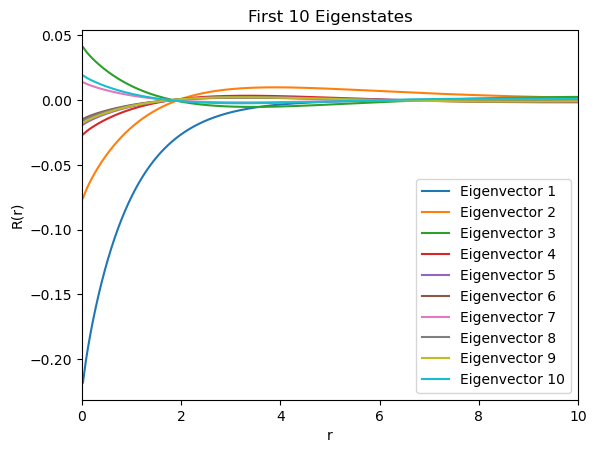

In [ ]:
N = 10000
x_inf = 100

del_r = x_inf/(1+ N)
r = np.linspace(del_r, N * del_r, N)

prelim_N = preliminary(0, x_inf, N)

e_hat, e_vec = sparse.linalg.eigsh(prelim_N, k=11, sigma=0)
e_n = e_hat - 1

def radial_wavefunction(u_vec, r):
    return (u_vec / r)

for i in range(0,10):
    u_numerical = e_vec[:, i]
    R_numerical = radial_wavefunction(u_numerical, r)
    plt.plot(r, R_numerical, label = f'Eigenvector {i+1}')

plt.title('First 10 Eigenstates')
plt.xlabel('r')
plt.ylabel('R(r)')
plt.xlim(0, 10)
plt.legend()
plt.show()

The last two eigenvectors seem to me more constrained, although the expectation is that they would oscillate more. This is because as r gets closer to x_inf it becomes more confined. This is also an issue which can be resolved with boundary conditions.

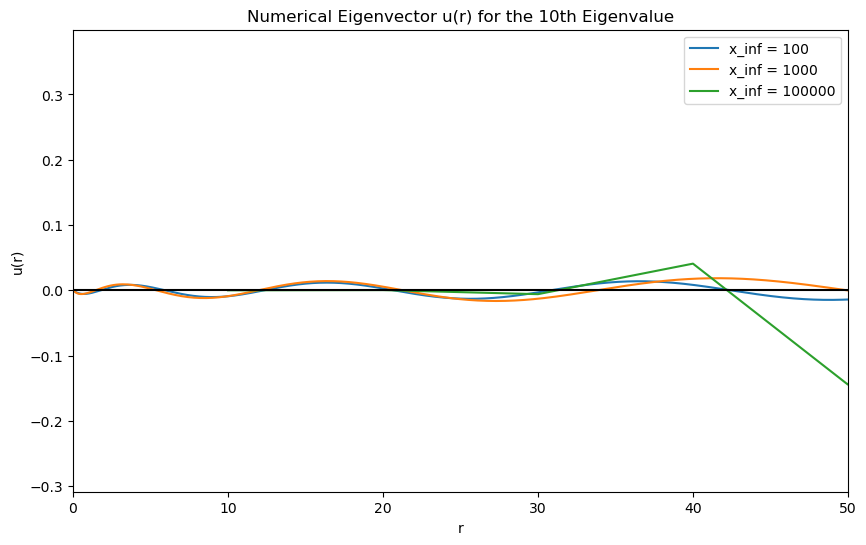

In [ ]:
def radial_wavefunction(u_vec):
    return u_vec

def plot_eigenvector(x_inf, N, k_eigenvalue=10):
    del_r = x_inf / (N + 1)
    r = np.linspace(del_r, N * del_r, N)

    prelim_N = preliminary(0, x_inf, N)
    e_hat, e_vec = eigsh(prelim_N, k=k_eigenvalue, sigma=0)

    u_numerical = e_vec[:, k_eigenvalue - 1]

    plt.plot(r, radial_wavefunction(u_numerical), label=f'x_inf = {x_inf}')

plt.figure(figsize=(10, 6))

N = 10000
plot_eigenvector(100, N)
plot_eigenvector(1000, N)
plot_eigenvector(100000, N)

plt.title('Numerical Eigenvector u(r) for the 10th Eigenvalue')
plt.xlabel('r')
plt.ylabel('u(r)')
plt.xlim(0, 50)
plt.axhline(y=0, color='black')
plt.legend()
plt.show()

As $x_{\infty}$ goes to actual infinity, the wavefunctions because more accurate and are able to estimate the true analytical form of the hydrogen atom's radial wavefunctions. But this is constrained by N, if N does not increase with $x_{\infty}$, then the approximation of the wavefunctions will be more constrained and therefore be less accurate. To get the MOST accurate data both $\Delta x$ and $x_{\infty}$ would be infinity.